In [1]:
import os

from IPython.display import Image, display

from PIL import ImageOps
from glob import glob
from pathlib import Path
import data
import Models

import keras
from keras.utils import load_img

import numpy as np

from tensorflow import data as tf_data
from tensorflow import image as tf_image
from tensorflow import io as tf_io

from dotenv import load_dotenv
import K_fold



In [2]:
load_dotenv()
env_path = Path('.')/'.env'
load_dotenv(dotenv_path=env_path)
PATH = os.getenv('DATA_PATH')

In [3]:

img_size = (512, 512)
num_classes = 3
batch_size = 32

(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = Data.load_data_and_split(PATH)

print("Number of training samples:", len(train_x))
print("Number of validation samples:", len(valid_x))
print("Number of test samples:", len(test_x))

print("Number of training samples:", train_x[8])
print("Number of training samples:", train_y[8])
print("Number of validation samples:", valid_x[8])
print("Number of validation samples:", valid_y[8])
print("Number of test samples:", test_x[8])
print("Number of test samples:", test_y[8])



Number of training samples: 186
Number of validation samples: 23
Number of test samples: 23
Number of training samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\images\40-012.jpg
Number of training samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\l_mask\40-012_L_mask.png
Number of validation samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\images\43-012.jpg
Number of validation samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\l_mask\43-012_L_mask.png
Number of test samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\images\33-015.jpg
Number of test samples: C:\Users\pinksterbha\OneDrive - UMCG\Studie\SGGS\data\DataSet\l_mask\33-015_L_mask.png


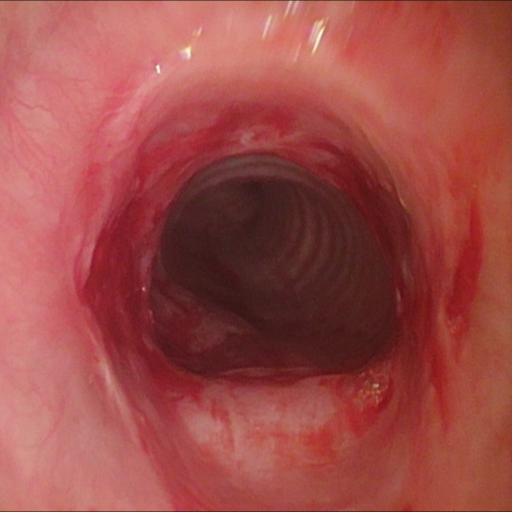

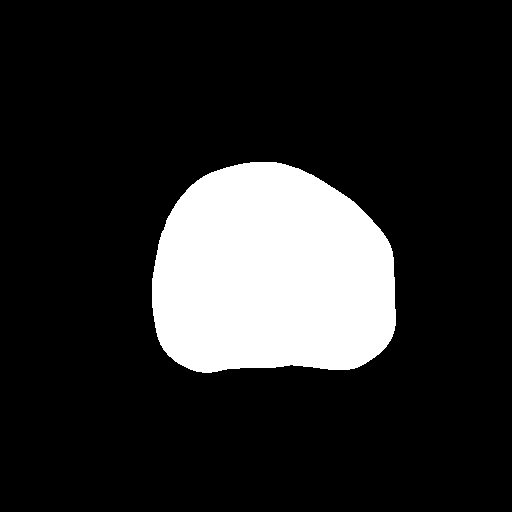

In [4]:
# Display input image #7
display(Image(filename=train_x[8]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = ImageOps.autocontrast(load_img(train_y[8]))
display(img)

In [5]:
def get_dataset(
    batch_size,
    img_size,
    input_img_paths,
    target_img_paths,
    max_dataset_len=None,
):
    """Returns a TF Dataset."""

    def load_img_masks(input_img_path, target_img_path):
        input_img = tf_io.read_file(input_img_path)
        input_img = tf_io.decode_png(input_img, channels=3)
        input_img = tf_image.resize(input_img, img_size)
        input_img = tf_image.convert_image_dtype(input_img, "float32")

        target_img = tf_io.read_file(target_img_path)
        target_img = tf_io.decode_png(target_img, channels=3)
        target_img = tf_image.resize(target_img, img_size, method="nearest")
        target_img = tf_image.convert_image_dtype(target_img, "uint8")

        # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
        target_img -= 1
        return input_img, target_img

    # For faster debugging, limit the size of data
    if max_dataset_len:
        input_img_paths = input_img_paths[:max_dataset_len]
        target_img_paths = target_img_paths[:max_dataset_len]
    dataset = tf_data.Dataset.from_tensor_slices((input_img_paths, target_img_paths))
    dataset = dataset.map(load_img_masks, num_parallel_calls=tf_data.AUTOTUNE)
    return dataset.batch(batch_size)

In [6]:
import Models

# Build model
model =Models.get_unet_model(image_size=img_size,num_classes=num_classes)
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 32)         0         ['batch_normalization[0]

In [ ]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(
    #optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
#)
model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="BinaryCrossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("SGGS_Unet.keras", save_best_only=True)
]

train_dataset = get_dataset(
    batch_size, img_size, train_x, train_y
)

valid_dataset = get_dataset(
    batch_size, img_size, valid_x, valid_y
)
# Train the model, doing validation at the end of each epoch.
epochs = 5
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

Epoch 1/5



In [12]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
#model.compile(
    #optimizer=keras.optimizers.Adam(1e-4), loss="sparse_categorical_crossentropy"
#)
folds = K_fold.create_k_folds(10, PATH)
n=0
for f in enumerate(folds):
    print(f)


model.compile(
    optimizer=keras.optimizers.Adam(1e-4), loss="BinaryCrossentropy"
)

callbacks = [
    keras.callbacks.ModelCheckpoint("SGGS_Unet.keras", save_best_only=True)
]

train_dataset = get_dataset(
    batch_size, img_size, train_x, train_y
)

valid_dataset = get_dataset(
    batch_size, img_size, valid_x, valid_y
)
# Train the model, doing validation at the end of each epoch.
epochs = 5
history = model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=valid_dataset,
    callbacks=callbacks,
    verbose=2,
)

AttributeError: module 'K_fold' has no attribute 'create_k_folds'

In [ ]:
# Generate predictions for all images in the validation set

test_dataset = get_dataset(
    batch_size, img_size, test_x, test_y
)
test_preds = model.predict(test_dataset)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.utils.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 10

# Display input image
display(Image(filename=test_x[i]))

# Display ground-truth target mask
img = ImageOps.autocontrast(load_img(test_y[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.